In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm

In [9]:
!wget -O- https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.chrom.sizes | sed 's/chr//' | grep -w -P "[1-9][0-9]?|X" | sort -k1n > hg38.chrom.sizes


--2024-05-10 14:23:43--  https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.chrom.sizes
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11672 (11K)
Saving to: ‘STDOUT’

-                   100%[===================>]  11.40K  --.-KB/s    in 0s      

2024-05-10 14:23:43 (182 MB/s) - written to stdout [11672/11672]



In [76]:
h2_estimates = pd.read_csv('Baldness_SNP_h2_proportions_by_chromosome_v2.txt', header=0, sep='\t')
h2_estimates.rename({'h2_not_proportoin': 'h2', "Chromosome": "chrom"}, axis=1, inplace=True)
chrom_sizes = pd.read_csv('hg38.chrom.sizes', names=['chrom', 'size'], sep='\t')
chrom_sizes = pd.concat([chrom_sizes.iloc[1:, :], chrom_sizes.iloc[:1, :]]).reset_index(drop=True)


bootstraps = []
for chrom, h2, se in zip(h2_estimates.chrom.values, h2_estimates.h2.values, h2_estimates.std_err_h2.values):
    bootstraps.append(norm.rvs(loc=h2, scale=se, size=10000))
bootstraps = np.stack(bootstraps)
bootstraps /= bootstraps.sum(axis=0)
low_ci = np.percentile(bootstraps, 2.5, axis=1)
high_ci = np.percentile(bootstraps, 97.5, axis=1)
ci = np.stack([low_ci, high_ci])

Text(0, 0.5, 'Proportion of Heritability')

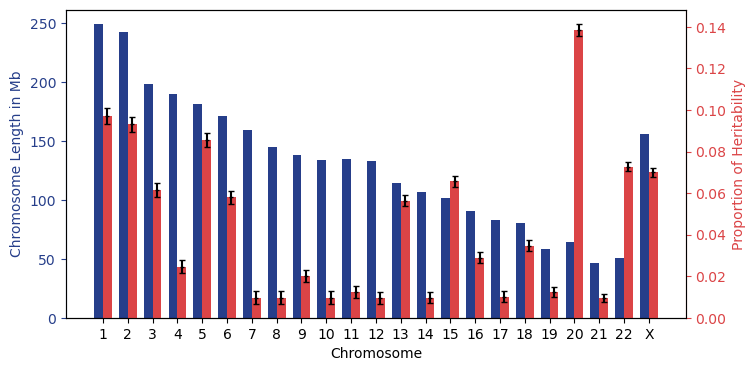

In [89]:
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()
ax.bar(chrom_sizes.index -0.25 + 0.4 * chrom_sizes.index, chrom_sizes['size'].values / 1e6, color='#263E8A', 
       width=0.5)
ax2.bar(h2_estimates.index + 0.25 + 0.4 * h2_estimates.index, 
        h2_estimates.h2.values / h2_estimates.h2.values.sum(), color='#DB4446', 
        width=0.5)
ax2.errorbar(h2_estimates.index + 0.25 + 0.4 * h2_estimates.index, 
             h2_estimates.h2.values / h2_estimates.h2.values.sum(),
             yerr = np.abs(ci - h2_estimates.h2.values / h2_estimates.h2.values.sum()),
             fmt='_', color='black', markersize=3, capsize=2)
ax.yaxis.label.set_color('#263E8A')
ax.spines['left'].set_color('#263E8A')
ax.tick_params(colors='#263E8A', axis='y') 
ax2.yaxis.label.set_color('#DB4446')
ax.spines['right'].set_color('#DB4446')
ax2.tick_params(colors='#DB4446', axis='y') 
ax.set_xlabel('Chromosome')
ax.set_ylabel("Chromosome Length in Mb")
ax.set_xticks(h2_estimates.index + 0.4 * h2_estimates.index)
ax.set_xticklabels(h2_estimates.chrom)
ax2.set_ylabel("Proportion of Heritability")